In [41]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Read in data:
# Cloud_Sections
cloud_sections = pd.read_csv('Cleaned/CLOUD_SECTIONS_Cleaned.csv', delimiter = ',', encoding = 'latin1')

# Designed_Pipe_Center
designed_centers = pd.read_csv('Cleaned/DESIGNED_Pipe_Centers_Cleaned.csv', delimiter = ',', encoding = 'latin1')

# Planes_Local_Global_Cleaned
p_info = pd.read_csv('Cleaned/Planes_Local_Global_Cleaned.csv', delimiter = ',', encoding = 'latin1')

In [42]:
# A List of sections, where each section is a list of tuples, and each tuple is the XY coordinates of a point on the point cloud
TuplePairsBySection = [] 
# A list of the Designed Center points and radius, each object in the list is a panda dataframe where there are as many rows as pipes
CenterList = [] 
# For n in the number of distinct sections
for n in range(cloud_sections.Section.nunique()): 
    # Grabs all dataframe rows in each distinct section
    grab = cloud_sections[cloud_sections["Section"] == "Section-{" + str(n) + "}"] 
    # Adds the individual X and Y points in each point cloud pair for the nth section
    TuplePairsBySection.append(list(zip(grab.X, grab.Y))) 
    # Adds the dataframe rows in each distinct section
    CenterList.append(designed_centers[designed_centers["Section"] == "Section-{" + str(n) + "}"]) 

In [43]:
# Arbitrary radius multiplier
N = 1.4
# A List of points in the point cloud, by section and pipe, that pass the first noise test
PassesFirstNoiseTestBySection = [] 
# A List of points in the point cloud, by section, that fail the first noise test
FailsFirstNoiseTestBySection = [] 
count = 0 
for section in TuplePairsBySection:
    D, E, F = [], [], []
    # Intialize the radius for both pipes
    r1, r2 = CenterList[count].iloc[0,4], CenterList[count].iloc[1,4] 
    # Intialize the center XY coordinate tuple for both pipes
    c1, c2 = tuple(CenterList[count].iloc[0,1:3]), tuple(CenterList[count].iloc[1,1:3]) 
    for point in section: 
        # Test first pipe
        if math.dist(c1, point) < (r1 * N): 
            D.append(point)
        # Test second pipe
        elif math.dist(c2, point) < (r2 * N): 
            E.append(point)
        else:
            F.append(point)
    PassesFirstNoiseTestBySection.append(D)
    PassesFirstNoiseTestBySection.append(E)
    FailsFirstNoiseTestBySection.append(F)
    count += 1

In [44]:
# Arbitrary IQR multiplier
M = 1.3

def findOutVals(rlist):
    P, F = {}, {}
    P_index = []
    sortedList = sorted(rlist)
    L = len(rlist)
    Q1 = np.median(sortedList[:(L//2 + 2)]) 
    Q3 = np.median(sortedList[(L//2 + 1):])
    IQR = Q3 - Q1
    L_out = Q1 - IQR*M
    R_out = Q3 + IQR*M
    count = 0
    for n in rlist:
        if (n > L_out) and (n < R_out):
            P[count] = n
        count += 1
    for a in P:
        P_index.append(a)
    return P_index

In [45]:
PassesSecondNoiseTestBySection = [] #A List of points in the point cloud, by section and pipe, that pass the first noise test
FailsSeconNoiseTestBySection = [] #A List of points in the point cloud, by section, that fail the first noise test
count = 0 
for circle in PassesFirstNoiseTestBySection:
    passPoints, failPoints = [], []
    if len(circle) == 0:
        count += 1
    else:
        ResList = []
        if count %2 == 0:
            r = CenterList[count // 2].iloc[0,4]
            c = tuple(CenterList[count // 2].iloc[0,1:3])
            for p in circle:
                ResList.append((math.dist(p, c) - r))
            Pass_index = findOutVals(ResList)
            for n in range(len(circle)):
                if n in Pass_index:
                    passPoints.append(circle[n])
                else:
                    failPoints.append(circle[n])                 
        else:
            r = CenterList[count // 2].iloc[1,4]
            c = tuple(CenterList[count // 2].iloc[1,1:3])
            for p in circle:
                ResList.append((math.dist(p, c) - r))
            findOutVals(ResList)
            Pass_index = findOutVals(ResList)
            for n in range(len(circle)):
                if n in Pass_index:
                    passPoints.append(circle[n])
                else:
                    failPoints.append(circle[n])
            count += 1       
    PassesSecondNoiseTestBySection.append(passPoints)
    FailsSeconNoiseTestBySection.append(failPoints)

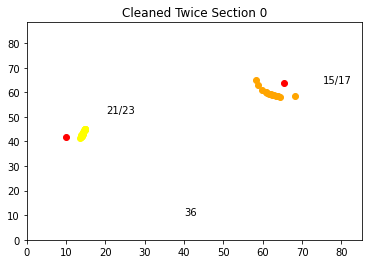

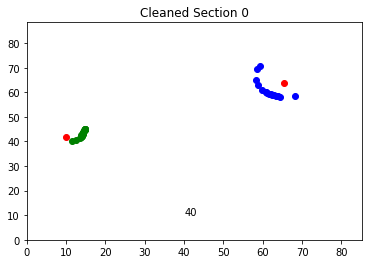

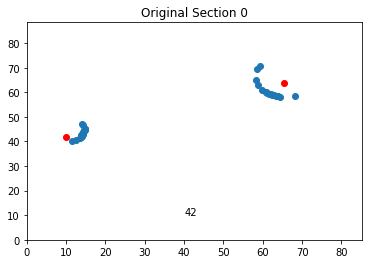

Circle 3 from Section 1 has no values.


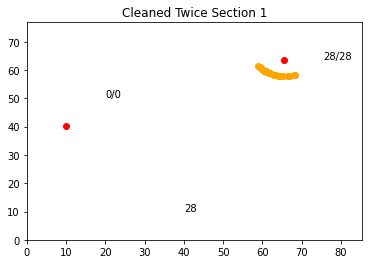

Circle 3 from Section 1 has no values


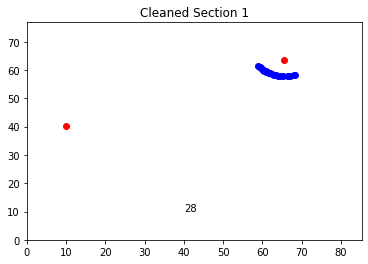

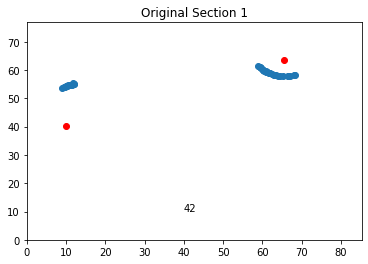

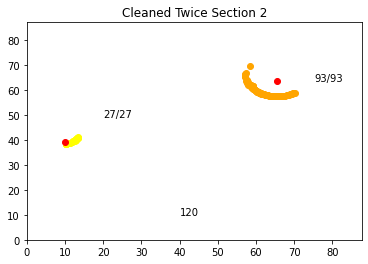

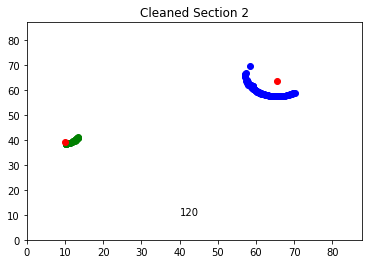

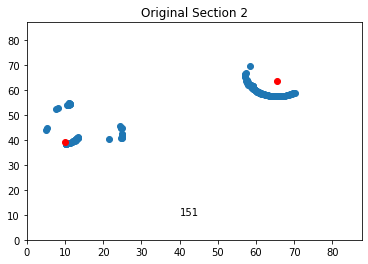

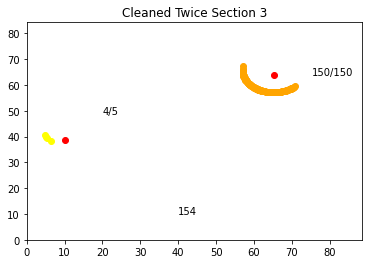

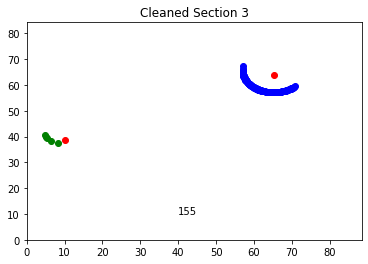

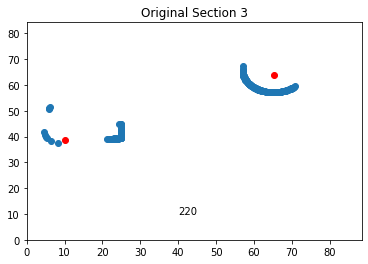

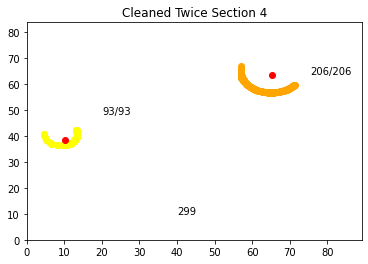

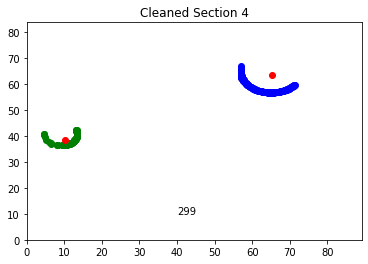

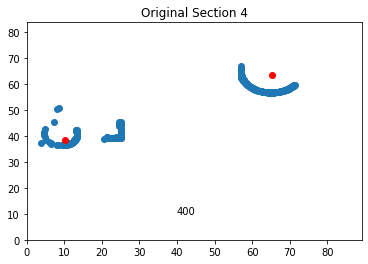

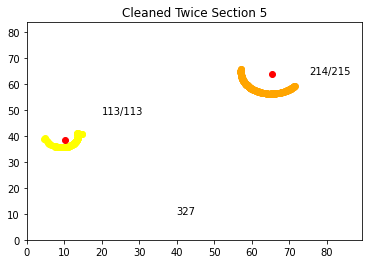

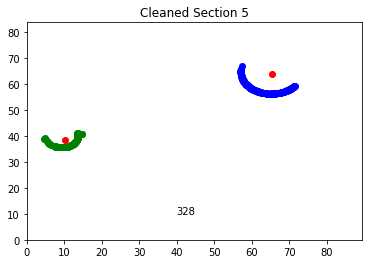

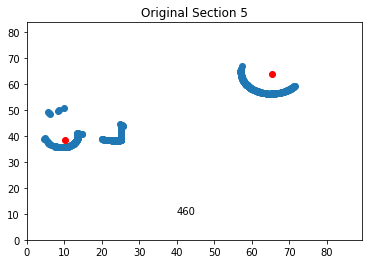

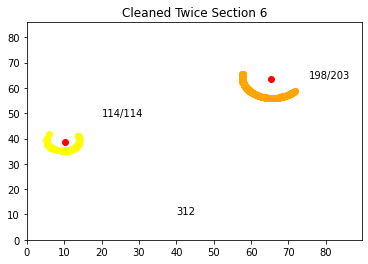

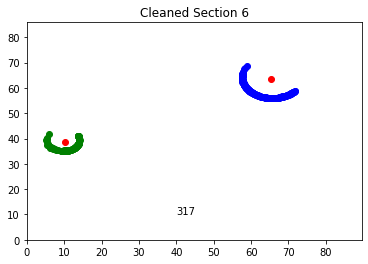

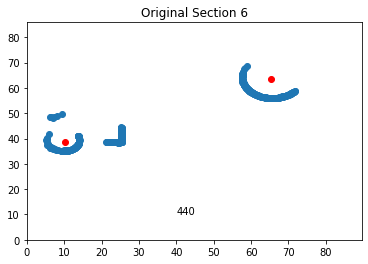

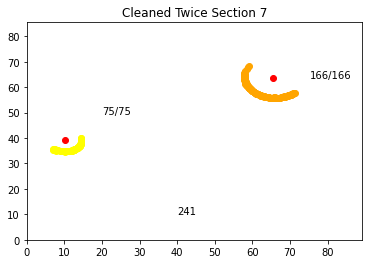

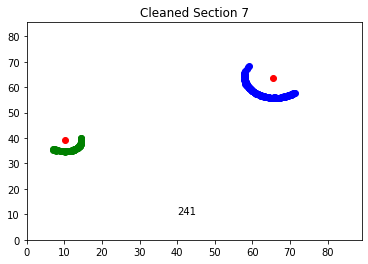

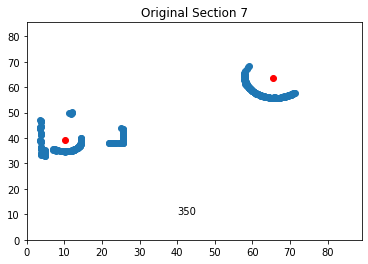

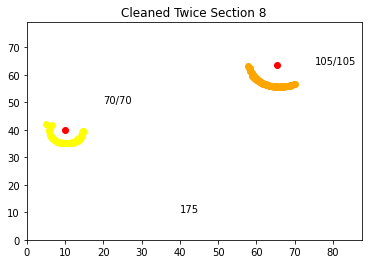

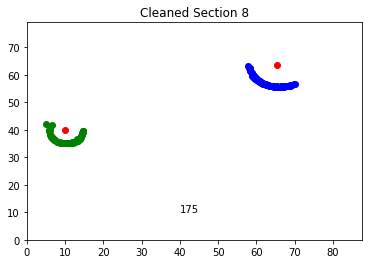

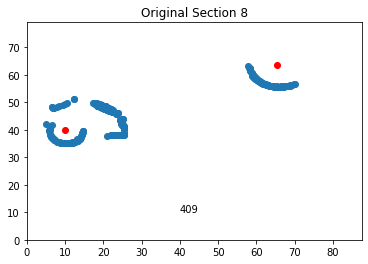

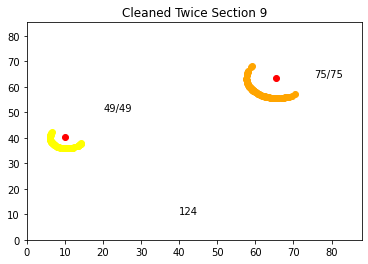

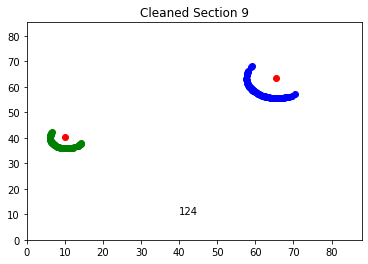

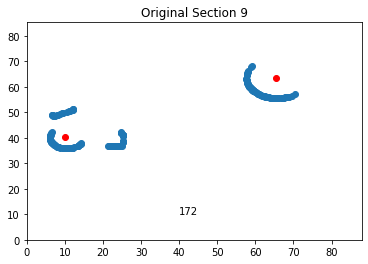

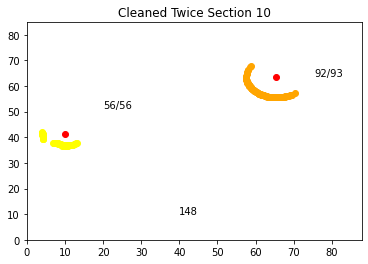

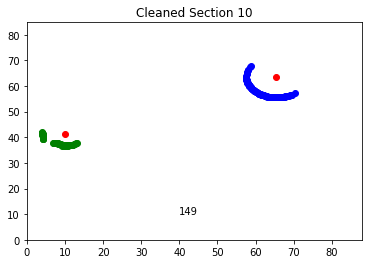

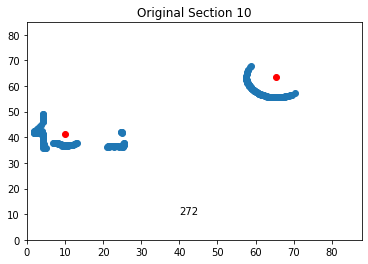

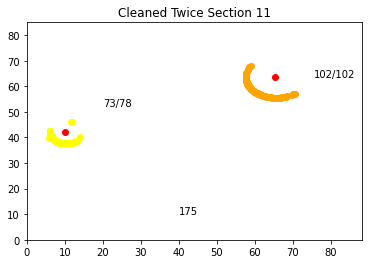

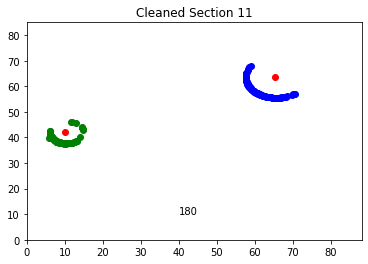

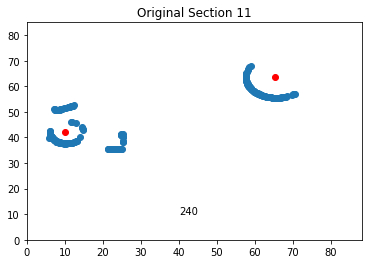

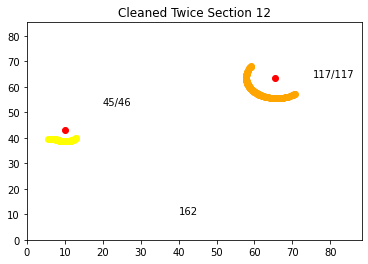

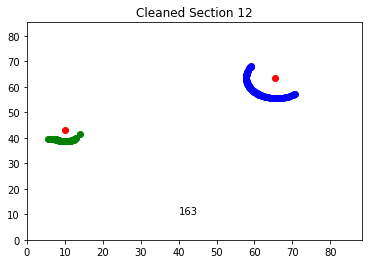

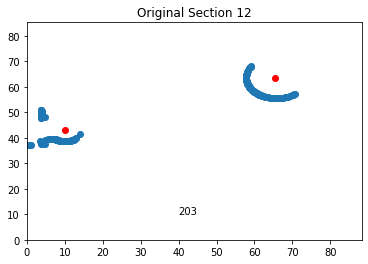

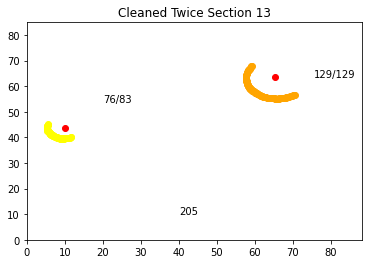

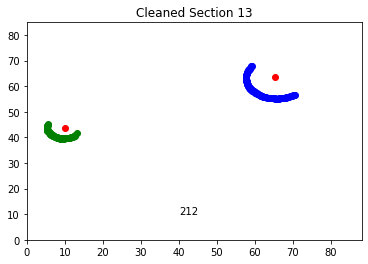

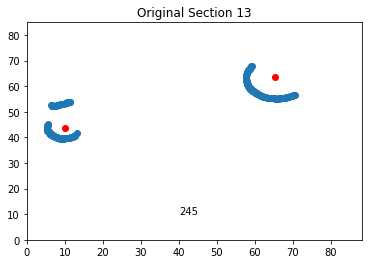

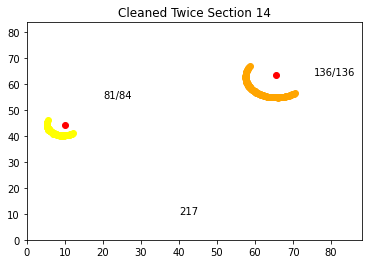

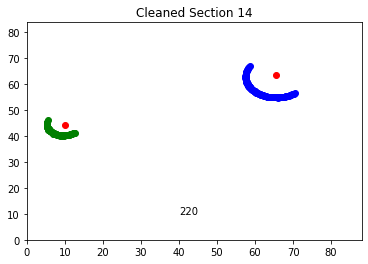

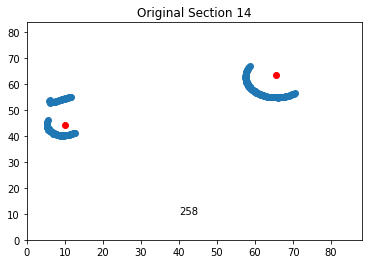

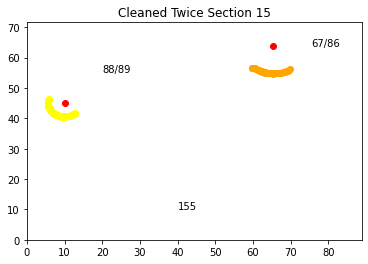

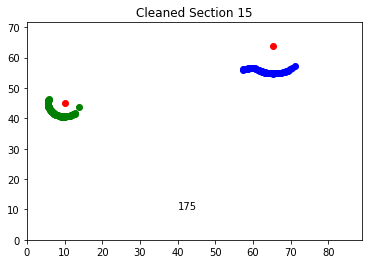

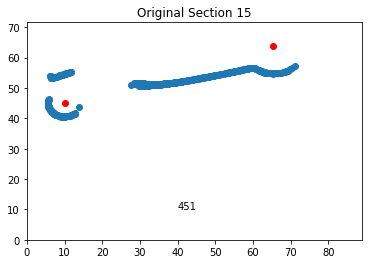

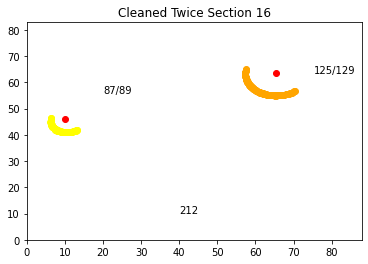

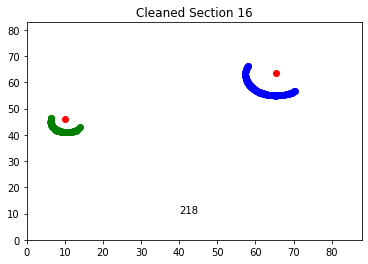

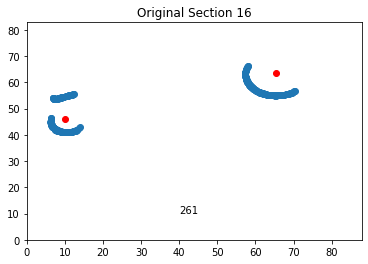

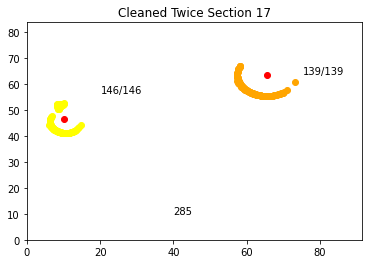

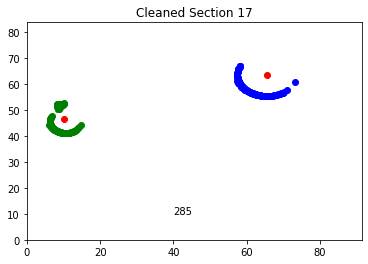

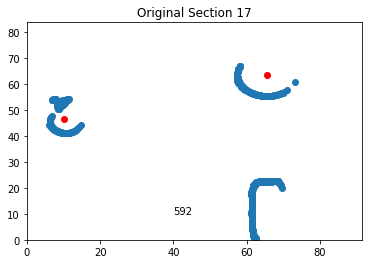

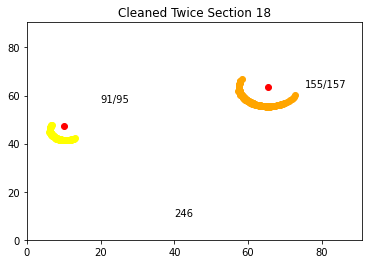

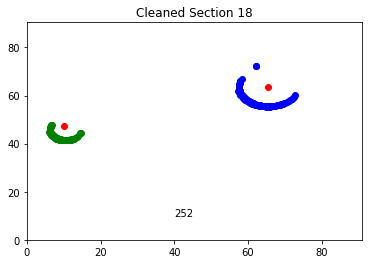

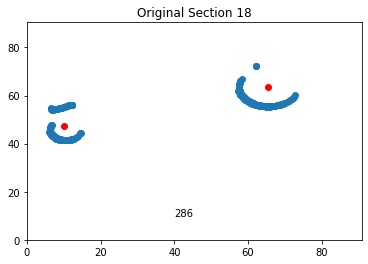

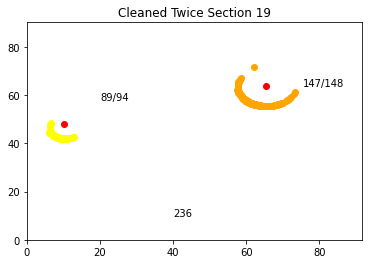

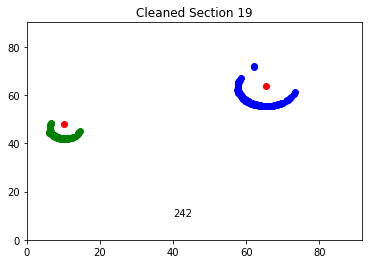

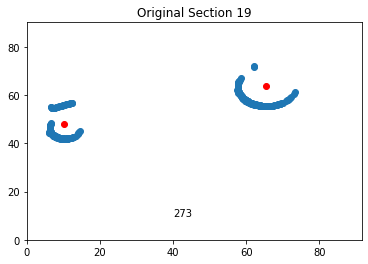

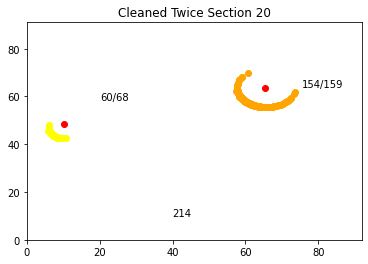

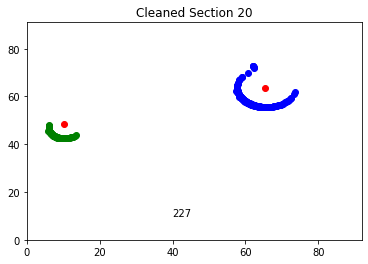

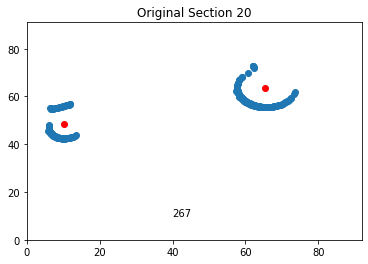

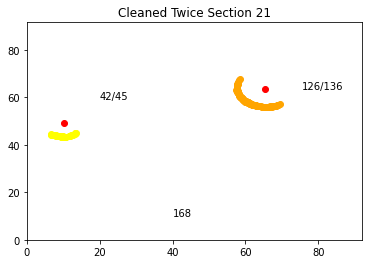

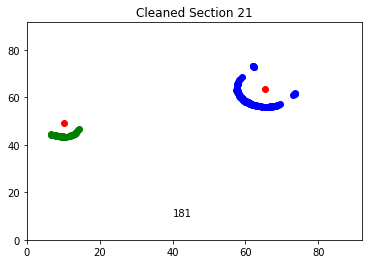

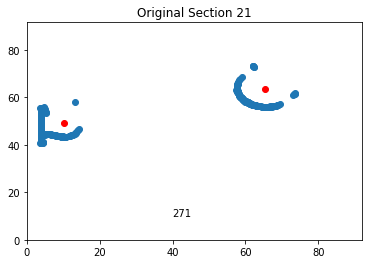

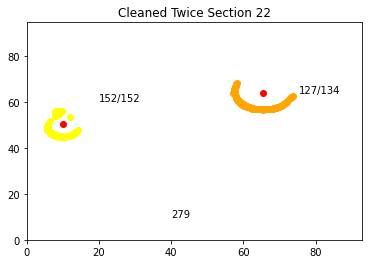

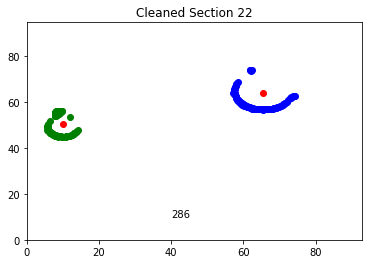

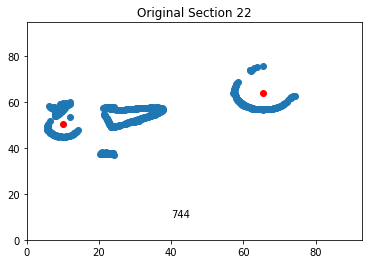

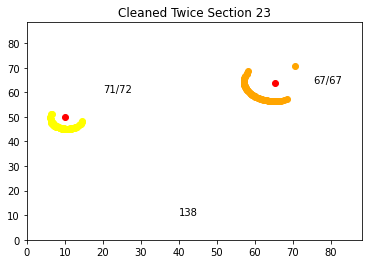

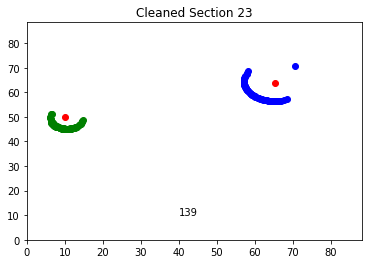

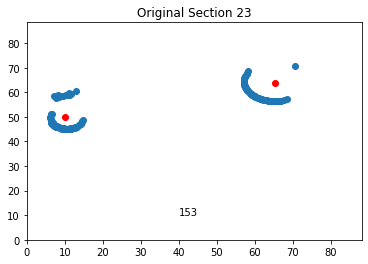

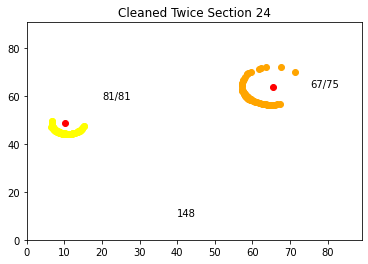

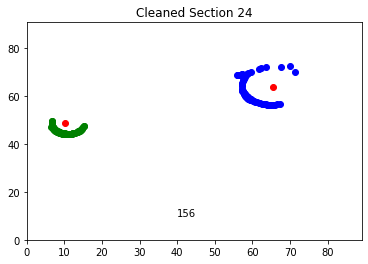

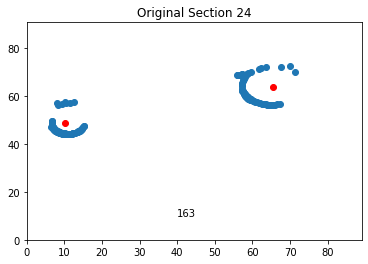

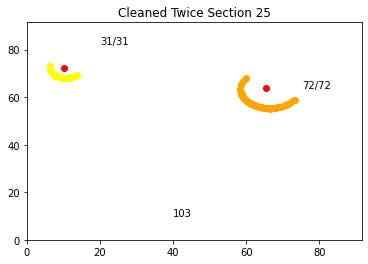

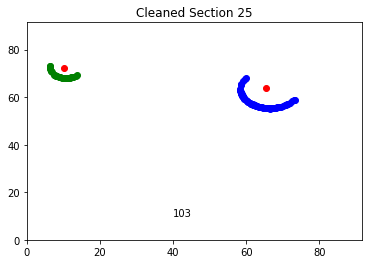

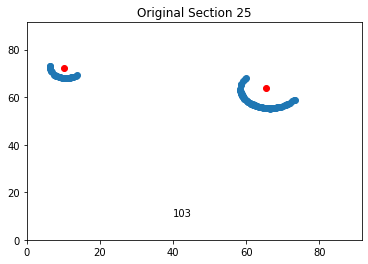

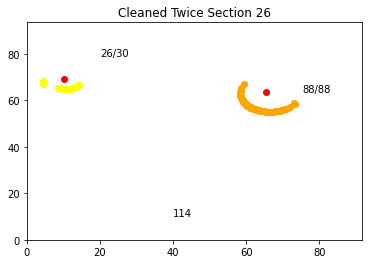

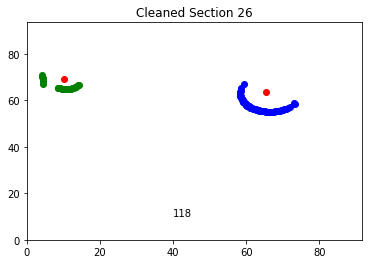

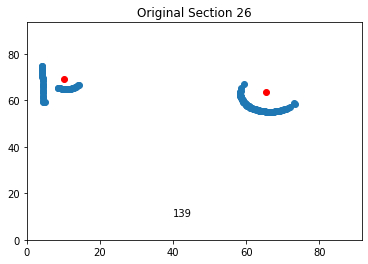

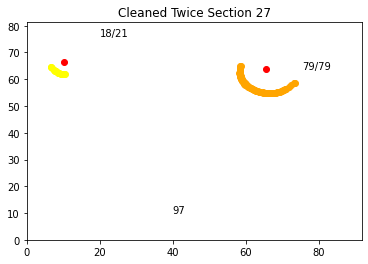

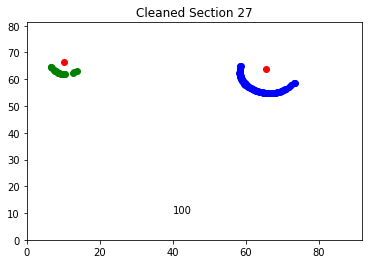

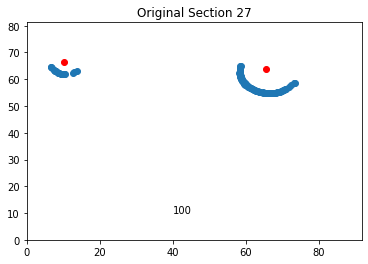

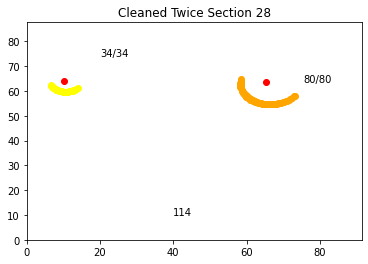

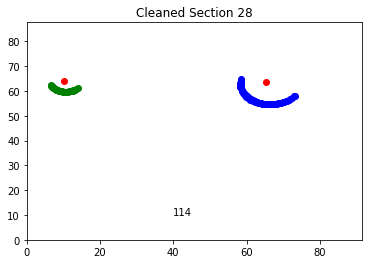

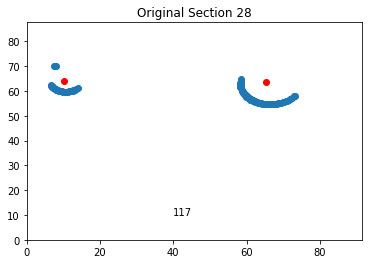

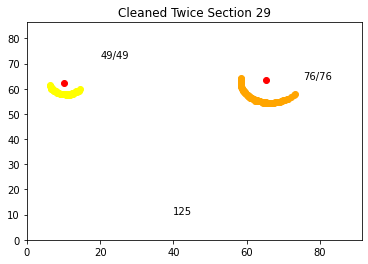

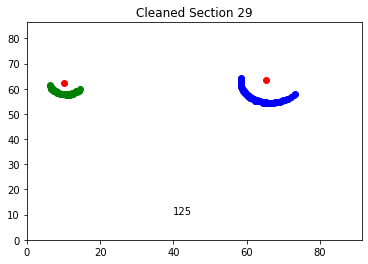

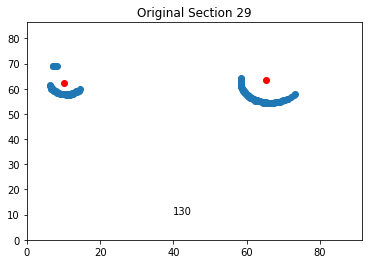

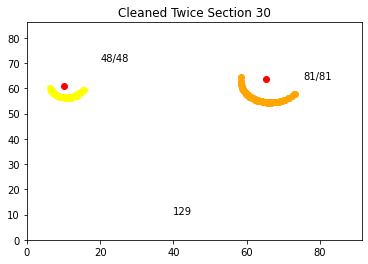

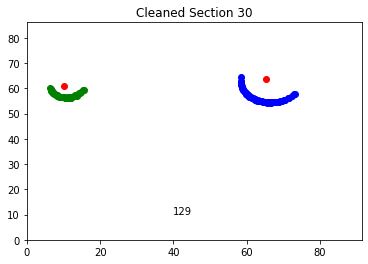

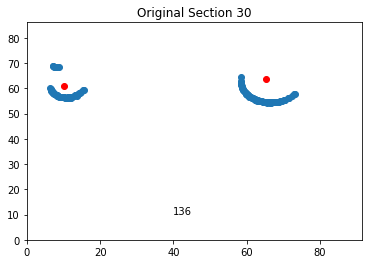

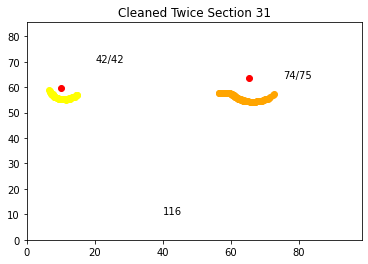

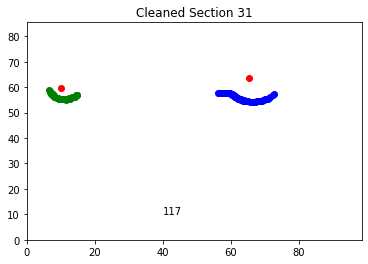

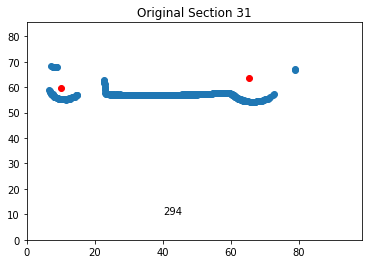

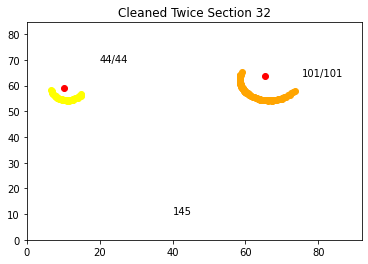

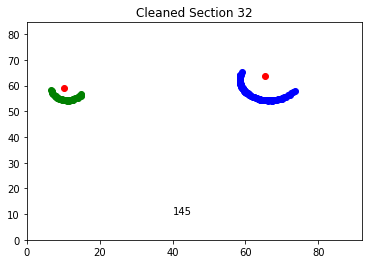

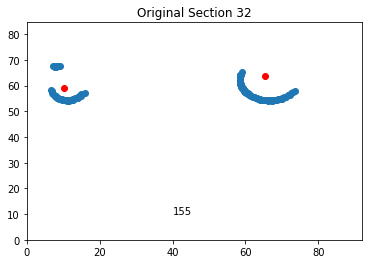

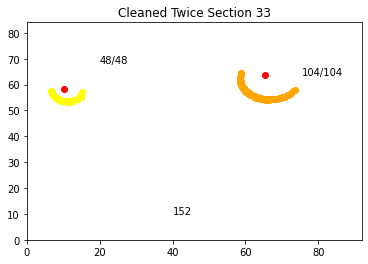

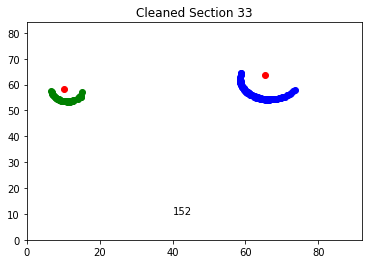

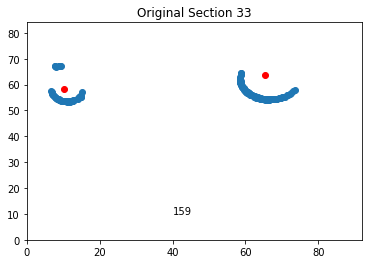

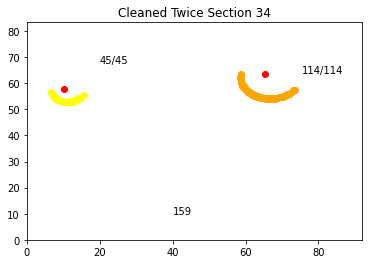

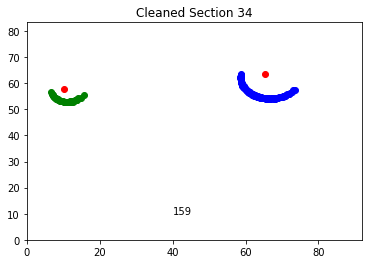

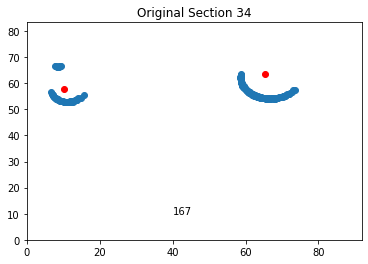

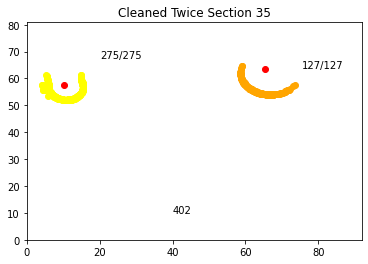

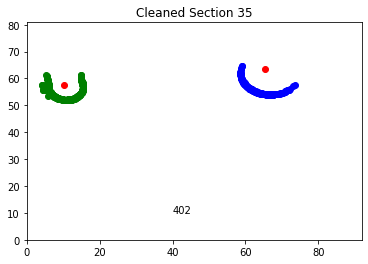

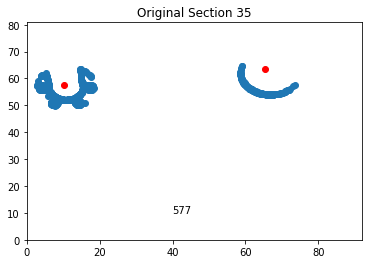

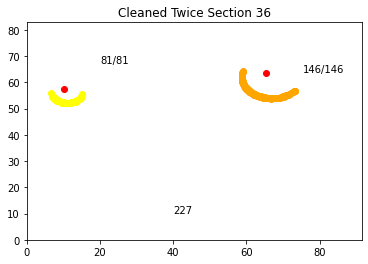

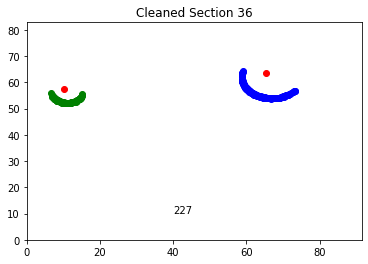

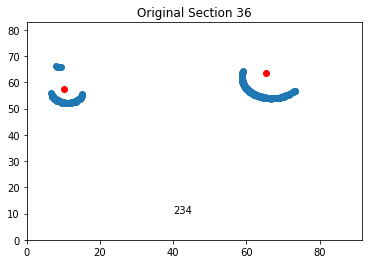

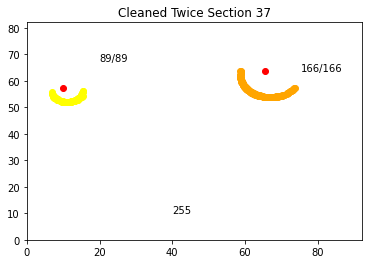

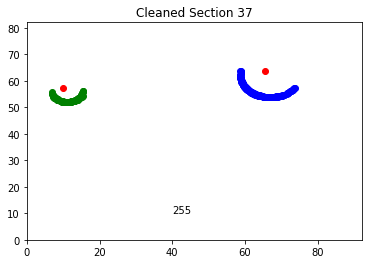

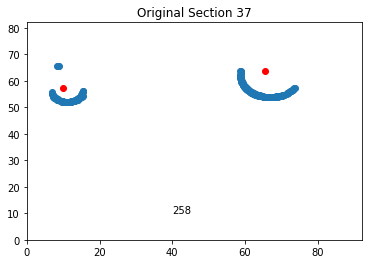

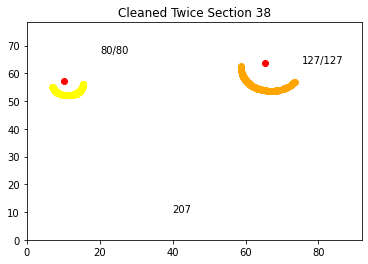

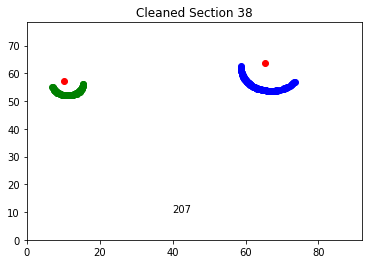

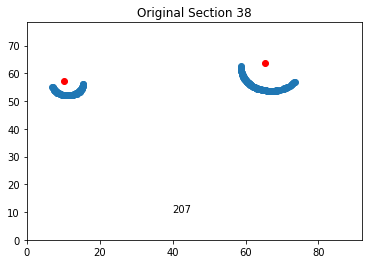

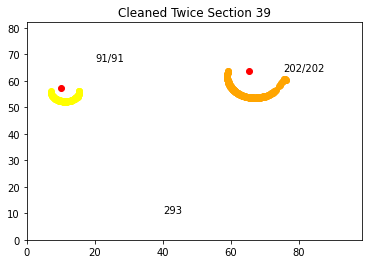

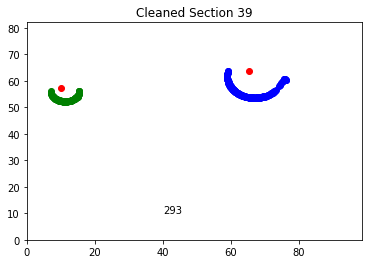

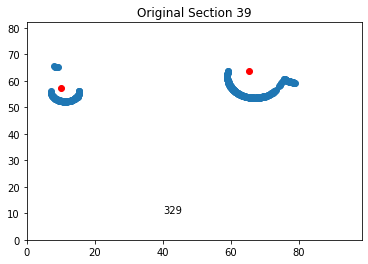

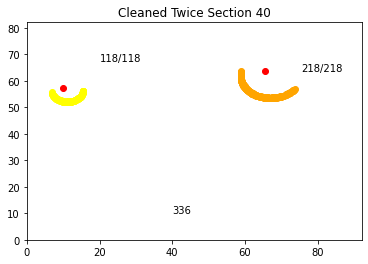

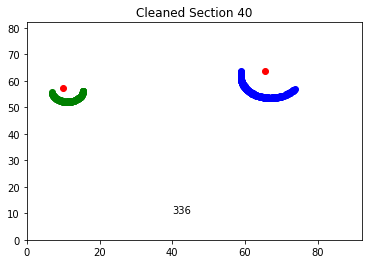

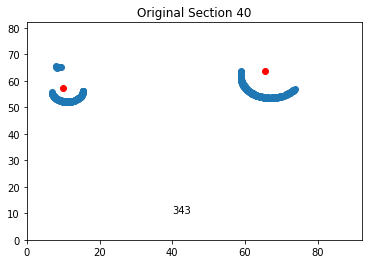

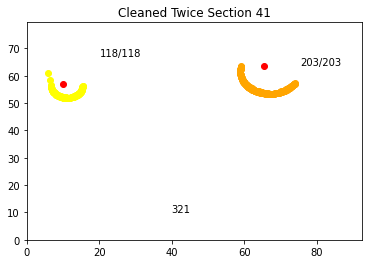

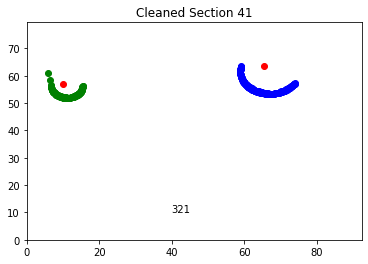

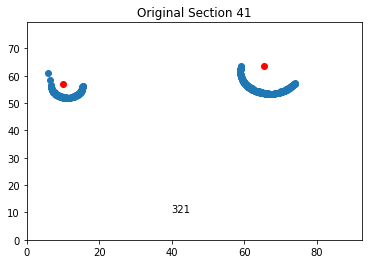

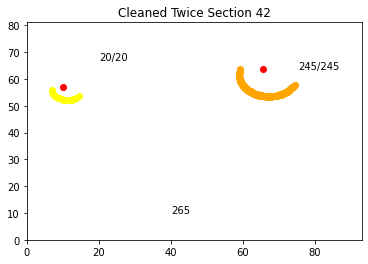

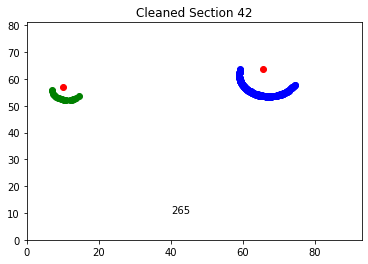

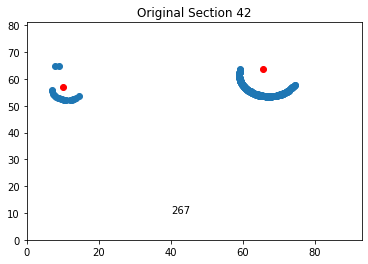

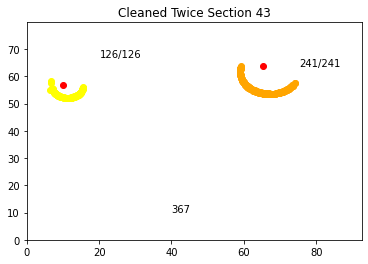

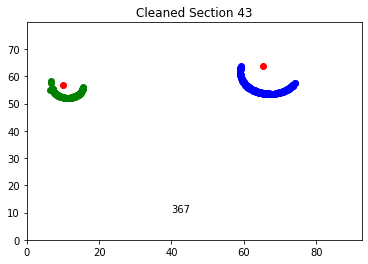

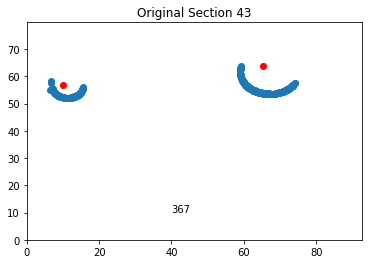

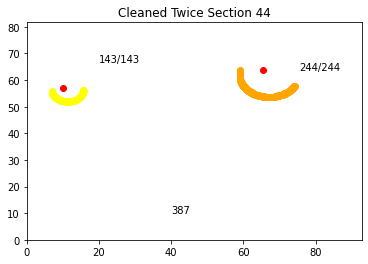

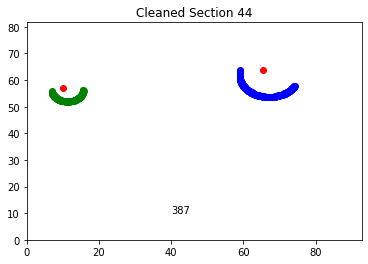

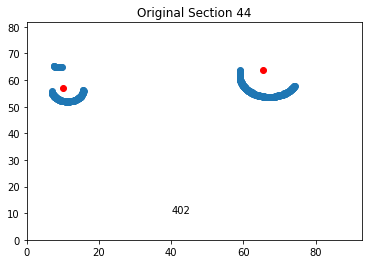

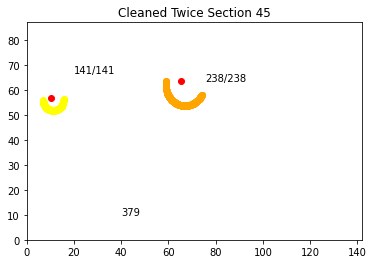

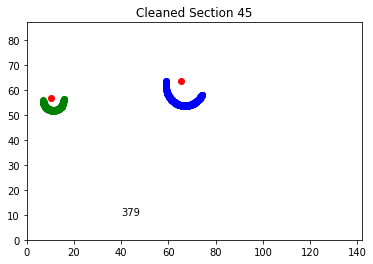

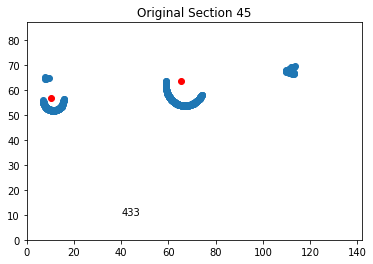

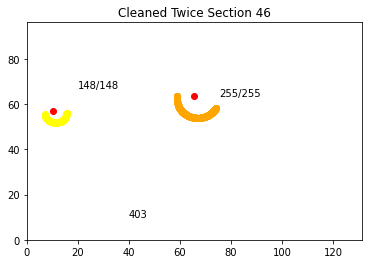

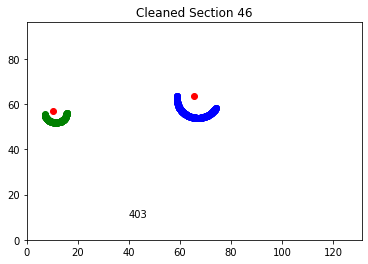

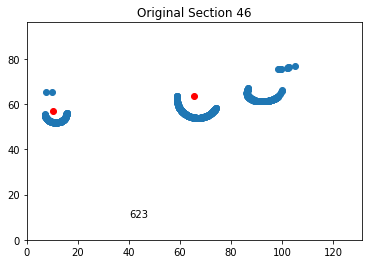

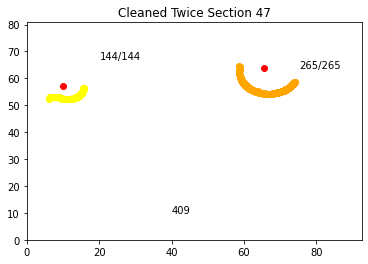

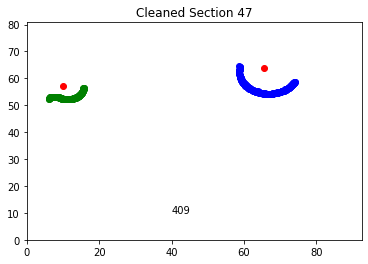

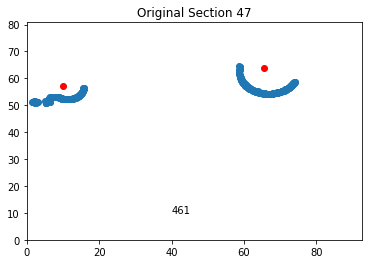

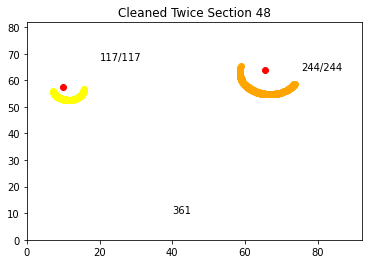

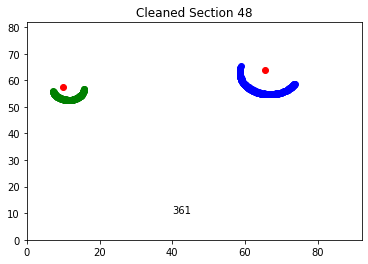

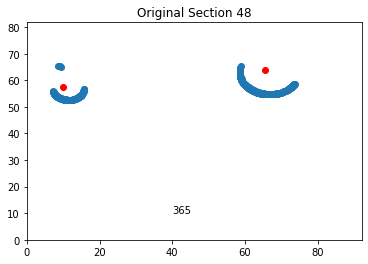

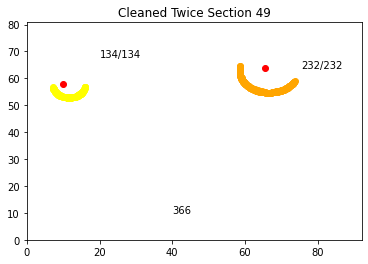

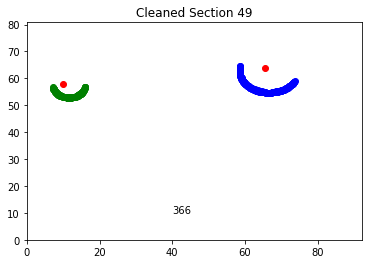

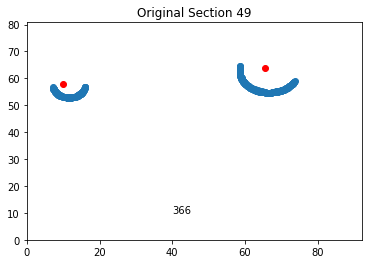

In [46]:
for NUM in range(0, 50):
    plt.title("Cleaned Twice Section " + str(NUM))
    plt.xlim(0, max(x[0] for x in TuplePairsBySection[NUM]) * 1.25)
    plt.ylim(0, max(y[1] for y in TuplePairsBySection[NUM]) * 1.25)
    if len(PassesSecondNoiseTestBySection[2 * NUM]) > 0: #Section 1 circle 3 workaround
        plt.scatter(*zip(*PassesSecondNoiseTestBySection[2 * NUM]), color = "orange") #Circle saved as D
    else: 
        print("Circle " + str(2 * NUM) + " from Section " + str(NUM) + " has no values.")

    plt.annotate(str(len(PassesSecondNoiseTestBySection[2 * NUM])) + "/" + str(len(PassesFirstNoiseTestBySection[2 * NUM])),
                 (CenterList[NUM].iloc[0,1] + 10, CenterList[NUM].iloc[0,2]))

    if len(PassesSecondNoiseTestBySection[2 * NUM + 1]) > 0: #Section 1 circle 3 workaround
        plt.scatter(*zip(*PassesSecondNoiseTestBySection[2 * NUM + 1]), color = "yellow")  #Circle saved as E
    else: 
        print("Circle " + str(2 * NUM + 1) + " from Section " + str(NUM) + " has no values.")

    plt.annotate(str(len(PassesSecondNoiseTestBySection[2 * NUM + 1])) + "/" + str(len(PassesFirstNoiseTestBySection[2 * NUM + 1])),
                  (CenterList[NUM].iloc[1,1] + 10, CenterList[NUM].iloc[1,2] + 10))

    plt.annotate(str(len(PassesSecondNoiseTestBySection[2 * NUM]) + len(PassesSecondNoiseTestBySection[2 * NUM + 1])), (40, 10))
    plt.scatter(CenterList[NUM].X, CenterList[NUM].Y, color = "red")
    plt.show()

    #Cleaned Section
    plt.title("Cleaned Section " + str(NUM))
    plt.xlim(0, max(x[0] for x in TuplePairsBySection[NUM]) * 1.25)
    plt.ylim(0, max(y[1] for y in TuplePairsBySection[NUM]) * 1.25)
    if len(PassesFirstNoiseTestBySection[2 * NUM]) > 0: #Section 1 circle 3 workaround
        plt.scatter(*zip(*PassesFirstNoiseTestBySection[2 * NUM]), color = "blue") #Circle saved as D
    else: 
        print("Circle " + str(2 * NUM) + " from Section " + str(NUM) + " has no values")

    if len(PassesFirstNoiseTestBySection[2 * NUM + 1]) > 0: #Section 1 circle 3 workaround
        plt.scatter(*zip(*PassesFirstNoiseTestBySection[2 * NUM + 1]), color = "green")  #Circle saved as E
    else: 
        print("Circle " + str(2 * NUM + 1) + " from Section " + str(NUM) + " has no values")
    plt.annotate(str(len(PassesFirstNoiseTestBySection[2 * NUM]) + len(PassesFirstNoiseTestBySection[2 * NUM + 1])), (40, 10))
    plt.scatter(CenterList[NUM].X, CenterList[NUM].Y, color = "red")
    plt.show()

    #Original Section
    plt.title("Original Section " + str(NUM))
    plt.xlim(0, max(x[0] for x in TuplePairsBySection[NUM]) * 1.25)
    plt.ylim(0, max(y[1] for y in TuplePairsBySection[NUM]) * 1.25)
    plt.scatter(*zip(*TuplePairsBySection[NUM]))
    plt.annotate(str(len(TuplePairsBySection[NUM])), (40, 10))
    plt.scatter(CenterList[NUM].X, CenterList[NUM].Y, color = "red")
    plt.show()